<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/9_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Краткая история нейронных сетей. Знакомство с многослойным персептроном](https://colab.research.google.com/drive/1-FEYLgNSN5kJyAOoaW9dOhDUABU8VJlc)
2. [Математический аппарат обучения нейронных сетей](https://colab.research.google.com/drive/1FtyyBXYq9FaOEknvu4ghim-ejuO_3aIZ)
3. [Обучение многослойного персептрона в TensorFlow (Практика)](https://colab.research.google.com/drive/1Q8ioc9pkkaqGravu37C7jKw9OaG7cNL0)
4. Домашняя работа

Используя модель обучения многослойного персептрона из практической части урока (9.3), выполните следующее:

1. Увеличьте число слоев до 4-х и сравните время обучения модели и точность на тестовой выборке.
2. В качестве датасета использовать любой из наборов данных TensorFlow. Обучить модель. Добейтесь результата распознования более 85% на тестовой выборке. [Датасеты на выбор](https://www.tensorflow.org/datasets/overview). Используйте датасет отличный от MNIST, который был в уроке.

Для прохождения урока достаточно решить первое задание.

In [1]:
# Устанавливаем Seaborn для построения графиков
# !pip install -q seaborn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import tempfile

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

# Установим по умолчанию размер фигуры для Matplotlib по умолчанию.
matplotlib.rcParams["figure.figsize"] = [9, 6]

In [3]:
train_data, val_data, test_data = tfds.load(
    "mnist",
    split=["train[10000:]", "train[0:10000]", "test"],
    batch_size=128,
    as_supervised=True,
)

2024-07-08 13:40:48.851841: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/Users/ads/Documents/Dev/Ads_2s/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 5/5 [00:06<00:00,  1.25s/ file]

Dataset mnist downloaded and prepared to /Users/ads/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Размерность исходных данных: (1500, 28, 28, 1)
Размерность данных после сжатия: (1500, 28, 28)


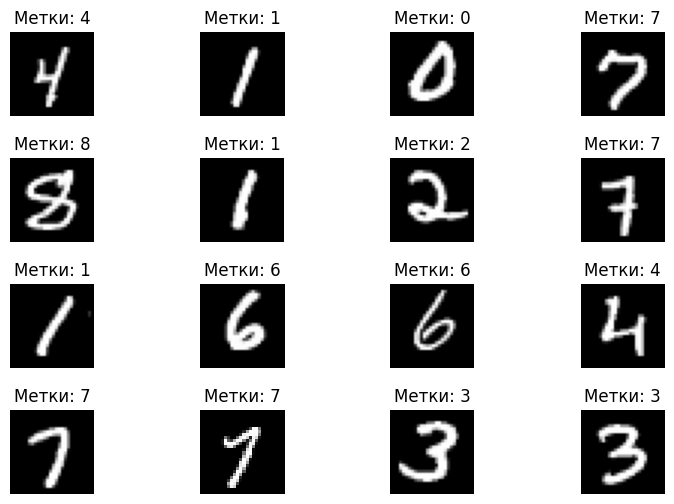

In [ ]:
x_viz, y_viz = tfds.load(
    "mnist", split=["train[:1500]"], batch_size=-1, as_supervised=True
)[0]  # Взять все одним батчем и выбрать его для визуализации
print("Размерность исходных данных:", x_viz.shape)
x_viz = tf.squeeze(
    x_viz, axis=3
)  # метод сжатия размерности, исключаем данные по оси с индексом 3
print("Размерность данных после сжатия:", x_viz.shape)

for i in range(16):  # Выводим 16 картинок из датасета
    plt.subplot(4, 4, 1 + i)
    plt.axis("off")
    plt.imshow(
        x_viz[i], cmap="gray"
    )  # отображение массива numpy как картинки; cmap - карта цветов, используем серую 'gray'
    plt.title(f"Метки: {y_viz[i]}")
    plt.subplots_adjust(
        hspace=0.5, wspace=0.5
    )  # Отступы по ширине и высоте между картинками

In [5]:
sns.countplot(x=list(train_data).numpy())
plt.xlabel("Цифры")
plt.ylabel("Штук")
plt.title("Распределение цифр в MNIST");

In [ ]:
# Функция изменения формы и масштабирования данных
def preprocess(x, y):
    # reshap - изменяет форму данных
    x = tf.reshape(
        x, shape=(-1, 784)
    )  # -1 - значит сохранить форму для заданного индекса матрицы, равносильно указать 1500
    # Масштабируем данные
    x = x / 255
    return x, y


train_data, val_data = (
    train_data.map(preprocess),
    val_data.map(preprocess),
)  # map выполняет функцию preprocess для каждого элемента данных, к которым применяется

In [ ]:
def xavier_init(shape):
    # Вычисляем значения инициализации xavier для весовой матрицы
    in_dim, out_dim = shape

    # Задаем диапазон инициализации весов по схеме Ксавье
    xavier_lim = tf.sqrt(6.0) / tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))

    # Возвращаем тензор с равномерно распределенными случайными величинами в указанном интервале.
    weight_vals = tf.random.uniform(
        shape=(in_dim, out_dim), minval=-xavier_lim, maxval=xavier_lim
    )
    return weight_vals

In [ ]:
class DenseLayer(tf.Module):
    def __init__(self, out_dim, weight_init=xavier_init, activation=tf.identity):
        # Инициализация размеров и функции активации
        self.out_dim = out_dim  # Определяем размерность выходов
        self.weight_init = weight_init  # Инициализируем веса
        self.activation = activation  # Задаем функцию активации
        self.built = False

    @tf.function  # Декоратор, который переносит вычисления на уровень графа TensorFlow
    def __call__(self, x):
        if not self.built:  # Если запущен первый раз проводим инициализацию
            # Вывод входного измерения на основе первого вызова
            self.in_dim = x.shape[1]
            # Инициализация весов и смещений
            self.w = tf.Variable(
                self.weight_init(shape=(self.in_dim, self.out_dim))
            )  # Объявление тензорных переменных
            self.b = tf.Variable(
                tf.zeros(shape=(self.out_dim,))
            )  # Объявление тензорных переменных
            self.built = True  # Инициализация пройдена
        # Вычисление прямого прохода
        y = tf.add(tf.matmul(x, self.w), self.b)  # уравнение персептрона
        return self.activation(
            y
        )  # Применение функции активации к уравнению персептрона

In [ ]:
class MLP(tf.Module):
    def __init__(self, layers):
        self.layers = layers

    @tf.function  # Декоратор, который переносит вычисления на уровень графа TensorFlow
    def __call__(self, x, preds=False):
        # Последовательное выполнение слоев модели
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
mlp_model = MLP(
    [
        DenseLayer(out_dim=700, activation=tf.nn.relu),
        DenseLayer(out_dim=500, activation=tf.nn.relu),
        DenseLayer(out_dim=250, activation=tf.nn.relu),
        DenseLayer(out_dim=10),
    ]
)

In [ ]:
def cross_entropy_loss(y_pred, y):
    # Вычисление перекрестной энтропии с помощью разреженной операции
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)  # аналог np.mean для тензоров

In [ ]:
def accuracy(y_pred, y):
    # Вычисляем точность после извлечения предсказаний класса
    class_preds = tf.argmax(
        tf.nn.softmax(y_pred), axis=1
    )  # возвращает индекс максимального элемента
    is_equal = tf.equal(y, class_preds)  # сравнение тензорных значений
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))  # аналог np.mean для тензоров

In [ ]:
class Adam:
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        # Инициализируем параметры оптимизатора и резервируем переменные
        self.beta_1 = beta_1  # гиперпараметр
        self.beta_2 = beta_2  # гиперпараметр
        self.learning_rate = learning_rate  # шаг обучения
        self.ep = (
            ep  # Эпсилон - предотвращает деление на ноль, слабо влияет на обучение
        )
        self.t = 1.0
        self.v_dvar, self.s_dvar = [], []
        self.built = False

    def apply_gradients(self, grads, vars):
        # Инициализируем переменные при первом вызове
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True
        # Обновите переменные модели с учетом их градиентов
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(
                self.beta_1 * self.v_dvar[i] + (1 - self.beta_1) * d_var
            )
            self.s_dvar[i].assign(
                self.beta_2 * self.s_dvar[i] + (1 - self.beta_2) * tf.square(d_var)
            )
            v_dvar_bc = self.v_dvar[i] / (1 - (self.beta_1**self.t))
            s_dvar_bc = self.s_dvar[i] / (1 - (self.beta_2**self.t))
            var.assign_sub(
                self.learning_rate * (v_dvar_bc / (tf.sqrt(s_dvar_bc) + self.ep))
            )
        self.t += 1.0
        return

In [ ]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
    # Обновляем состояние модели с учетом пакета данных
    with tf.GradientTape() as tape:
        y_pred = model(x_batch)  # Предсказываем значение с текущими весами
        batch_loss = loss(y_pred, y_batch)  # Оцениваем ошибку на текущих весах
    batch_acc = acc(y_pred, y_batch)  # Оцениваем точность на текущих весах
    grads = tape.gradient(batch_loss, model.variables)  # Вычисляем градиенты
    optimizer.apply_gradients(
        grads, model.variables
    )  # Обновляем переменные с учетом полученных градиентов
    return (
        batch_loss,
        batch_acc,
    )  # Возвращаем ошибку и точность на основе заданного пакета


def val_step(x_batch, y_batch, loss, acc, model):
    # Оцениваем модель на основе заданного пакета валидационных данных без обучения на текущих весах
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
    batch_acc = acc(y_pred, y_batch)
    return batch_loss, batch_acc

In [ ]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
    # Инициализация структур данных
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # Отформатируем тренировочный цикл и начнем обучение
    for epoch in range(epochs):
        batch_losses_train, batch_accs_train = [], []
        batch_losses_val, batch_accs_val = [], []

        # Выполняем итерацию по обучающим данным
        for x_batch, y_batch in train_data:
            # Вычисляем градиенты и обновляем параметры модели
            batch_loss, batch_acc = train_step(
                x_batch, y_batch, loss, acc, mlp, optimizer
            )
            # Следим за результатами обучения на пакетном уровне
            batch_losses_train.append(batch_loss)
            batch_accs_train.append(batch_acc)

        # Повторяем процедуру проверки данных
        for x_batch, y_batch in val_data:
            batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
            batch_losses_val.append(batch_loss)
            batch_accs_val.append(batch_acc)

        # Следим за производительностью модели на уровне эпохи
        train_loss, train_acc = (
            tf.reduce_mean(batch_losses_train),
            tf.reduce_mean(batch_accs_train),
        )
        val_loss, val_acc = (
            tf.reduce_mean(batch_losses_val),
            tf.reduce_mean(batch_accs_val),
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Эпоха: {epoch}")
        print(
            f"Обучающая ошибка: {train_loss:.3f}, Обучающая точность: {train_acc:.3f}"
        )
        print(
            f"Валидационная ошибка: {val_loss:.3f}, Валидационная точность: {val_acc:.3f}"
        )
    return train_losses, train_accs, val_losses, val_accs

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(
    mlp_model,
    train_data,
    val_data,
    loss=cross_entropy_loss,
    acc=accuracy,
    optimizer=Adam(),
    epochs=10,
)

Эпоха: 0
Обучающая ошибка: 0.225, Обучающая точность: 0.935
Валидационная ошибка: 0.121, Валидационная точность: 0.965
Эпоха: 1
Обучающая ошибка: 0.080, Обучающая точность: 0.975
Валидационная ошибка: 0.094, Валидационная точность: 0.972
Эпоха: 2
Обучающая ошибка: 0.048, Обучающая точность: 0.985
Валидационная ошибка: 0.090, Валидационная точность: 0.974
Эпоха: 3
Обучающая ошибка: 0.033, Обучающая точность: 0.990
Валидационная ошибка: 0.103, Валидационная точность: 0.973
Эпоха: 4
Обучающая ошибка: 0.026, Обучающая точность: 0.992
Валидационная ошибка: 0.087, Валидационная точность: 0.978
Эпоха: 5
Обучающая ошибка: 0.021, Обучающая точность: 0.993
Валидационная ошибка: 0.110, Валидационная точность: 0.973
Эпоха: 6
Обучающая ошибка: 0.019, Обучающая точность: 0.993
Валидационная ошибка: 0.103, Валидационная точность: 0.976
Эпоха: 7
Обучающая ошибка: 0.020, Обучающая точность: 0.993
Валидационная ошибка: 0.100, Валидационная точность: 0.978
Эпоха: 8
Обучающая ошибка: 0.014, Обучающая точн

In [ ]:
def plot_metrics(train_losses, val_losses, metric_name):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, "b", label="Training Loss")
    plt.plot(epochs, val_losses, "r", label="Validation Loss")

    plt.title(metric_name)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

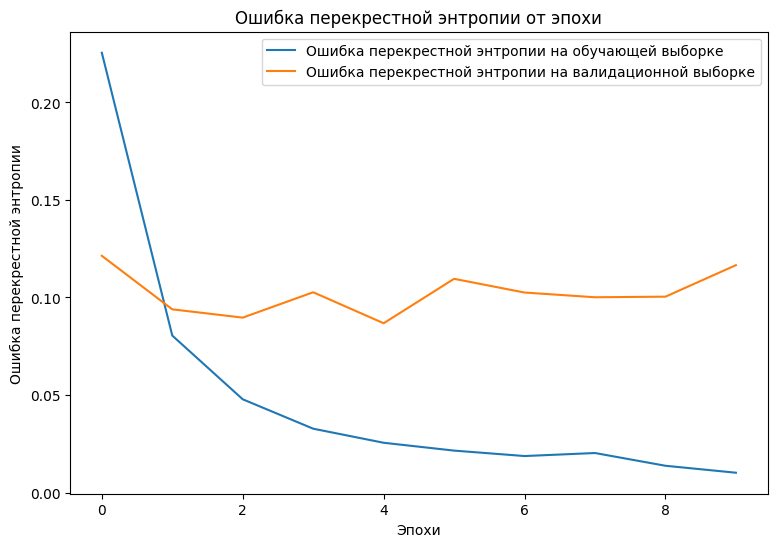

In [ ]:
plot_metrics(train_losses, val_losses, "Ошибка перекрестной энтропии")

In [ ]:
class ExportModule(tf.Module):
    def __init__(self, model, preprocess, class_pred):
        # Инициализация функций предобработки и постобработки
        self.model = model
        self.preprocess = preprocess
        self.class_pred = class_pred

    @tf.function(
        input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)]
    )
    def __call__(self, x):
        # Запускаем модуль экспорта для получения новых точек данных
        x = self.preprocess(x)
        y = self.model(x)
        y = self.class_pred(y)
        return y

In [ ]:
def preprocess_test(x):
    # Модуль экспорта принимает необработанные и немаркированные данные
    x = tf.reshape(x, shape=[-1, 784])
    x = x / 255
    return x


def class_pred_test(y):
    # Сгенерируем прогнозы классов на основе выходных данных MLP
    return tf.argmax(tf.nn.softmax(y), axis=1)

In [ ]:
mlp_model_export = ExportModule(
    model=mlp_model, preprocess=preprocess_test, class_pred=class_pred_test
)

In [ ]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, "mlp_model_export")
tf.saved_model.save(mlp_model_export, save_path)

In [ ]:
mlp_loaded = tf.saved_model.load(save_path)

In [ ]:
def accuracy_score(y_pred, y):
    # Общая функция точности
    is_equal = tf.equal(y_pred, y)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))


x_test, y_test = tfds.load("mnist", split=["test"], batch_size=-1, as_supervised=True)[
    0
]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Точность на тестовой выборке: {test_acc:.3f}")

Точность на тестовой выборке: 0.977


In [ ]:
print("Точность с разбивкой по цифрам :")
print("---------------------------")
label_accs = {}
for label in range(10):
    label_ind = y_test == label
    # extract predictions for specific true label
    pred_label = test_classes[label_ind]
    labels = y_test[label_ind]
    # compute class-wise accuracy
    label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
    print(f"Цифра {label_accs[key]}: {key:.3f}")

Точность с разбивкой по цифрам :
---------------------------
Цифра 2: 0.965
Цифра 0: 0.970
Цифра 4: 0.970
Цифра 9: 0.972
Цифра 5: 0.974
Цифра 7: 0.977
Цифра 6: 0.983
Цифра 8: 0.986
Цифра 3: 0.987
Цифра 1: 0.988


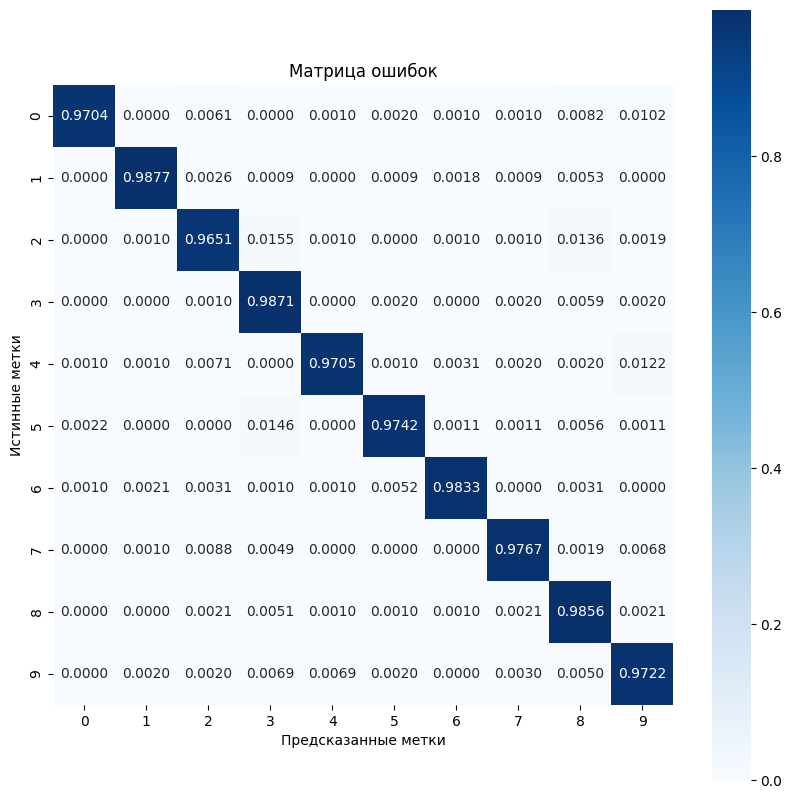

In [ ]:
def show_confusion_matrix(test_labels, test_classes):
    # Вычисление матрицы ошибок и ее нормализация
    plt.figure(figsize=(10, 10))
    confusion = sk_metrics.confusion_matrix(test_labels.numpy(), test_classes.numpy())
    confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
    axis_labels = range(10)
    ax = sns.heatmap(
        confusion_normalized,
        xticklabels=axis_labels,
        yticklabels=axis_labels,
        cmap="Blues",
        annot=True,
        fmt=".4f",
        square=True,
    )
    plt.title("Матрица ошибок")
    plt.ylabel("Истинные метки")
    plt.xlabel("Предсказанные метки")


show_confusion_matrix(y_test, test_classes)

# Задание 2

In [6]:
# Загрузка датасета Groove из TensorFlow Datasets
dataset, info = tfds.load("groove/full-16000h", with_info=True)

Dl Completed...: 100%|██████████| 8/8 [00:03<00:00,  2.22 file/s]


Dataset groove downloaded and prepared to /Users/ads/tensorflow_datasets/groove/full-midionly/2.0.1. Subsequent calls will reuse this data.


In [4]:
# Разделение на тренировочный, валидационный и тестовый наборы
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

print(info)

In [ ]:
def extract_bpm(dataset):
    bpms = []
    for data in dataset:
        bpm = data["bpm"].numpy()
        bpms.append(bpm)
        counter += 1
    return np.array(bpms)


train_bpms = extract_bpm(train_data)
val_bpms = extract_bpm(val_data)
test_bpms = extract_bpm(test_data)

# Построение графика распределения по BPM
plt.figure(figsize=(10, 6))
plt.hist(train_bpms, bins=30, edgecolor="k", alpha=0.7, label="Train")
plt.hist(val_bpms, bins=30, edgecolor="k", alpha=0.7, label="Validation")
plt.hist(test_bpms, bins=30, edgecolor="k", alpha=0.7, label="Test")
plt.title("Распределение по BPM")
plt.xlabel("BPM")
plt.ylabel("Количество")
plt.legend()
plt.show()

In [ ]:
max_bpm = np.max(np.concatenate((train_bpms, val_bpms, test_bpms)))
print(max_bpm)

In [ ]:
# Функция для подготовки данных
def preprocess(dataset):
    def normalize(x):
        bpm = x["bpm"] / max_bpm
        return bpm, bpm

    dataset = dataset.map(normalize)
    dataset = dataset.batch(32)
    return dataset


train_dataset = preprocess(train_data)
val_dataset = preprocess(val_data)
test_dataset = preprocess(test_data)

In [ ]:
# Создаем модель
def create_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(128, activation="relu", input_shape=(1,)),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


model = create_model()

In [ ]:
# Обучаем модель
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

In [ ]:
# Оценка модели
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Средняя абсолютная ошибка на тестовых данных: {test_mae}")

In [ ]:
# Процент успешного определения (например, если ошибка меньше определенного порога)
threshold = 0.05
successful_predictions = np.sum(
    np.abs(predictions.flatten() - np.array(test_true_bpm)) < threshold
)
total_predictions = len(test_true_bpm)
success_rate = (successful_predictions / total_predictions) * 100
print(f"Процент успешного определения BPM: {success_rate:.2f}%")